In [1]:
%matplotlib inline

In [2]:
import numpy as np
import json, gzip
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

In [3]:
greco_numu = np.load('/data/user/apizzuto/Nova/skylab_dataset/v2.3/dataset_scripts/all_fields/IC86_2012.numu.npy')
delta_cos_theta = 2.
gfu = np.load('/data/ana/analyses/gfu/current/IC86_2011_MC.npy')
#mc = 
def initialize_aeff(mc):
    r'''In cm^2'''
    d_omega = 2. * np.pi * delta_cos_theta
    if np.max(mc['trueE']) < 1e3:
        E_bins = np.logspace(0., 3., 31)
    else:
        E_bins = np.logspace(0., 9., 31)
    logE_bins = np.log10(E_bins)
    dlog_E = np.diff(logE_bins)
    weights = mc['ow'] / (mc['trueE'] * dlog_E[np.digitize(np.log10(mc['trueE']), bins = logE_bins) -1] * d_omega * np.log(10.))
    h, b = np.histogram(mc['trueE'], weights = weights, bins = E_bins)
    aeff_dict = {'bins': b, 'vals': h}
    return aeff_dict

aeff_dict = initialize_aeff(greco_numu)
#aeff_dict = initialize_aeff(gfu)
def aeff(en):
    #aeff_dict = initialize_aeff(greco_numu)
    bin_centers = mids(aeff_dict['bins'])
    aeffs = np.interp(en, bin_centers, aeff_dict['vals'])
    return aeffs

def mids(arr):
    return arr[:-1] + (np.diff(arr) / 2.)

def dN_dE(ens, gamma=-2.0):
    return aeff(ens)*np.power(ens, gamma)

def diff_sens(center_en, num_ev = 2.3, num_days = 1.0):
    low_en = center_en / (np.power(10., 0.5))
    time_int_norm = sp.integrate.quad(dN_dE, low_en, low_en*10.)[0]
    norm = num_ev / (time_int_norm * 86400. * num_days) #norm has units 1/GeV cm^2 s
    norm *= 1e-3
    return norm

In [4]:
with gzip.open('../models/transient_flare_1day.json.gz') as f:
    flare_1day = json.load(f)

In [5]:
ct = np.array(flare_1day['data']['cos_zenith'])
sin_dec = -(ct[1:]+ct[:-1])/2.

In [6]:
erg_to_TeV = 0.624151
nu_model = np.loadtxt('../models/16ma_neutrino.txt').T
mu_flux = (nu_model[2] + nu_model[4]) / 2. * erg_to_TeV
e_flux = (nu_model[1] + nu_model[3]) / 2. * erg_to_TeV
ens = nu_model[0]

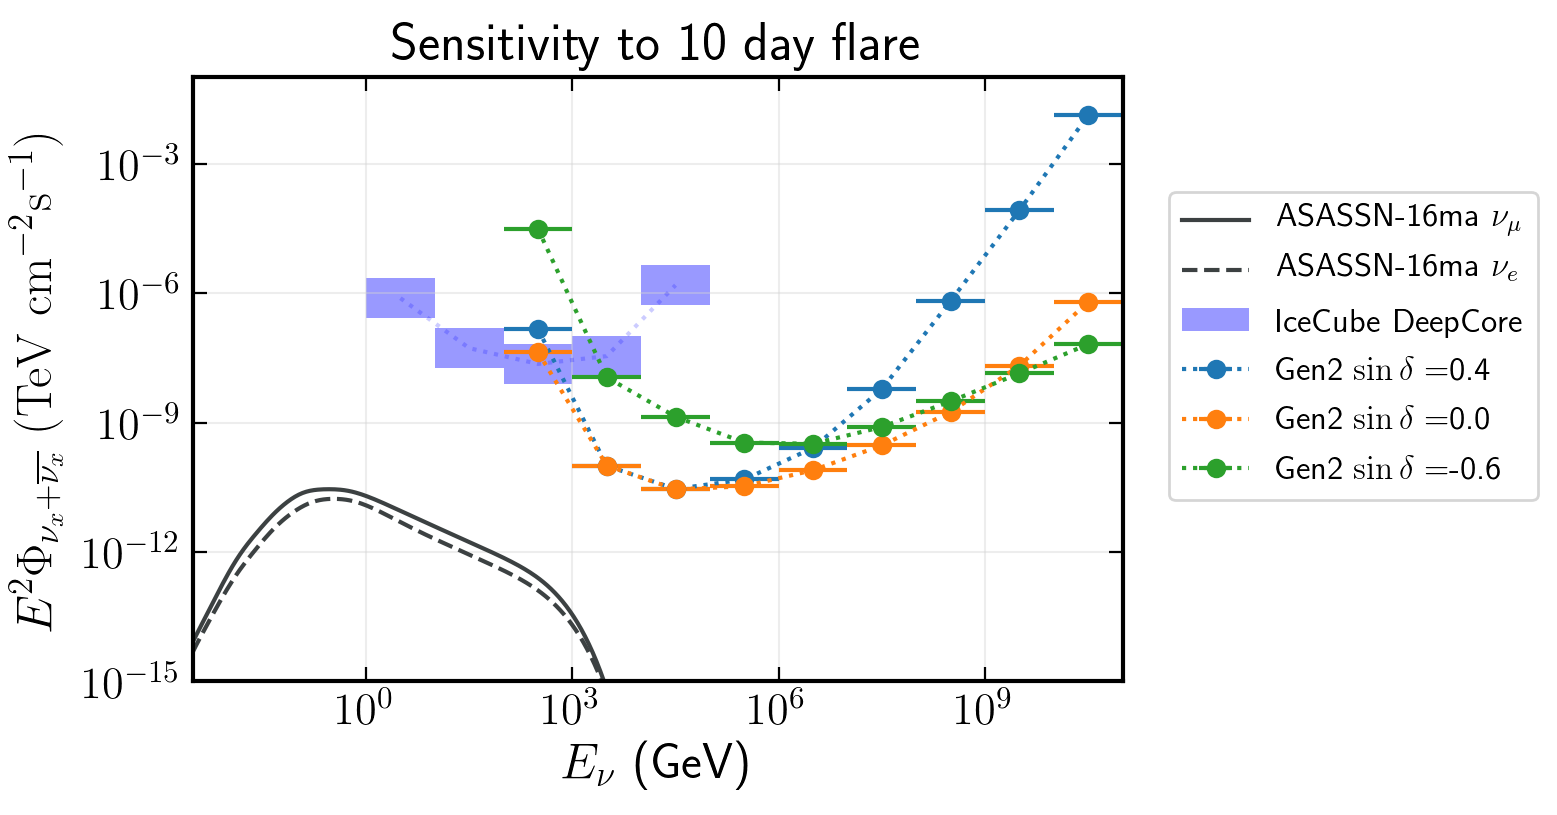

In [33]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (5, 9, 15):
    for dlabel in ['Gen2']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

cents = np.logspace(0., 5., 11)[1::2]
edges = np.logspace(0., 5., 11)[::2]
greco_diff_low = np.array([diff_sens(cent) for cent in cents])
greco_diff_high = np.array([diff_sens(cent, num_ev=20) for cent in cents])
greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

for ii, cent in enumerate(cents):
    if ii == 0:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0, label = 'IceCube DeepCore')
    else:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0)
plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
plt.title("Sensitivity to 10 day flare")
        
plt.loglog()
plt.ylim(1e-15, 1e-1)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/ASASSN-16ma_models_gen2_and_greco.png', bbox_inches='tight',
           dpi=200)
plt.show()

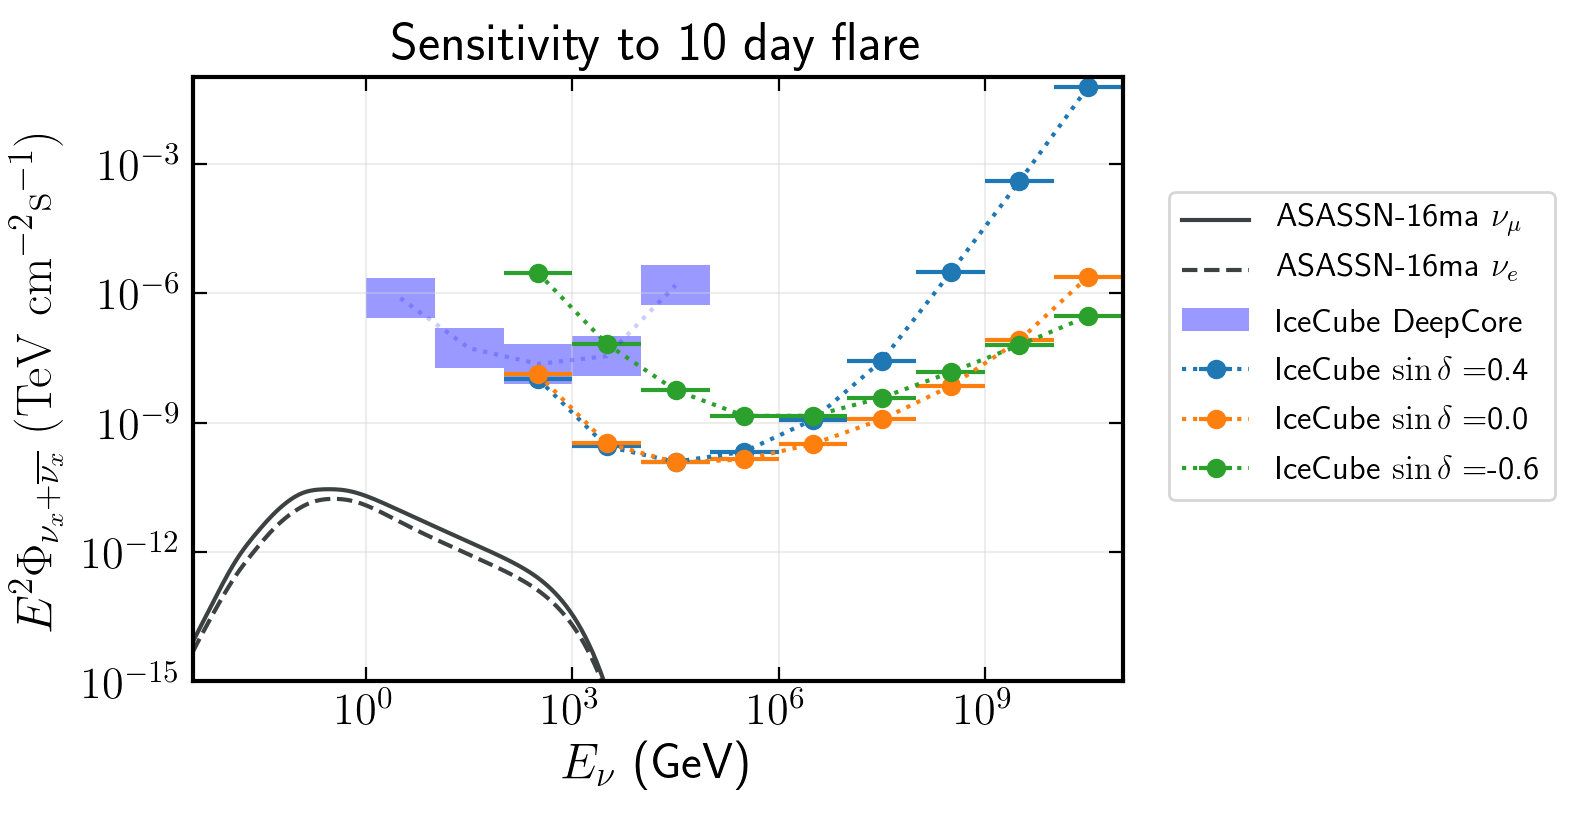

In [35]:
fig = plt.figure(figsize=(6,4), dpi=200)
fig.set_facecolor('w')

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (5, 9, 15):
    for dlabel in ['IceCube']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

cents = np.logspace(0., 5., 11)[1::2]
edges = np.logspace(0., 5., 11)[::2]
greco_diff_low = np.array([diff_sens(cent) for cent in cents])
greco_diff_high = np.array([diff_sens(cent, num_ev=20) for cent in cents])
greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

for ii, cent in enumerate(cents):
    #low_en = cent-cent/bin_width
    #high_en = cent*bin_width-cent 
    if ii == 0:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0, label = 'IceCube DeepCore')
    else:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0)
plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
plt.title("Sensitivity to 10 day flare")
        
plt.loglog()
plt.ylim(1e-15, 1e-1)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/ASASSN-16ma_models_IceCube_and_greco.png', bbox_inches='tight',
           dpi=200)
plt.show()

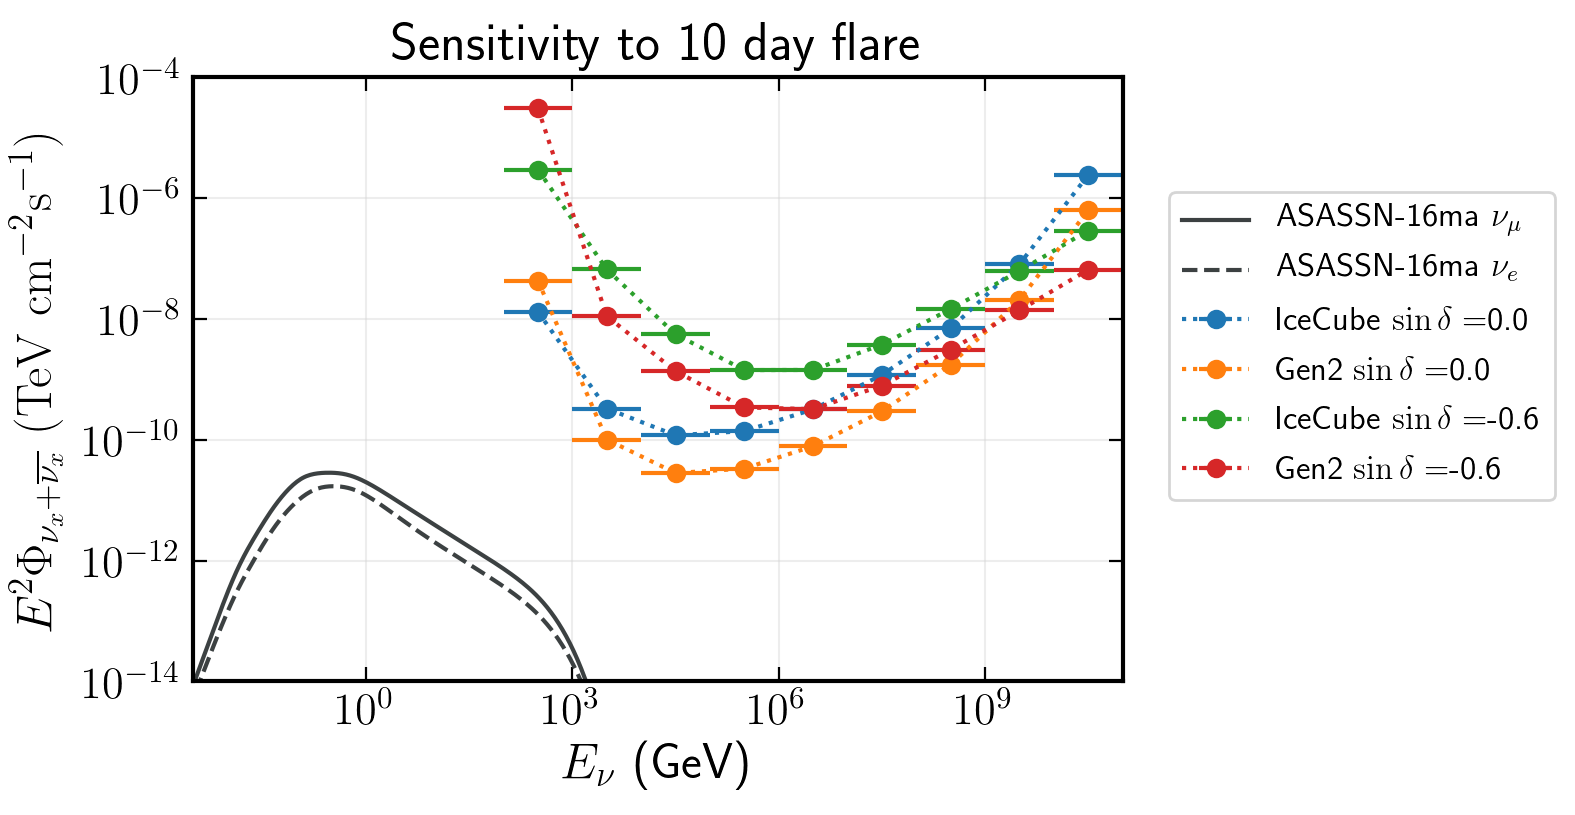

In [19]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (9, 15):
    for dlabel in ['IceCube', 'Gen2']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

#cents = np.logspace(0., 5., 11)[1::2]
#edges = np.logspace(0., 5., 11)[::2]
#greco_diff_low = np.array([diff_sens(cent) for cent in cents])
#greco_diff_high = np.array([diff_sens(cent, num_ev=20) for cent in cents])
#greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

#for ii, cent in enumerate(cents):
#    low_en = cent-cent/bin_width
#    high_en = cent*bin_width-cent 
#    if ii == 0:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0, label = 'IceCube DeepCore')
#    else:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0)
#plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
     
plt.title("Sensitivity to 10 day flare")
plt.loglog()
plt.ylim(1e-14, 1e-4)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/ASASSN-16ma_models_IceCube_vs_Gen2.png', bbox_inches='tight',
           dpi=200)
plt.show()

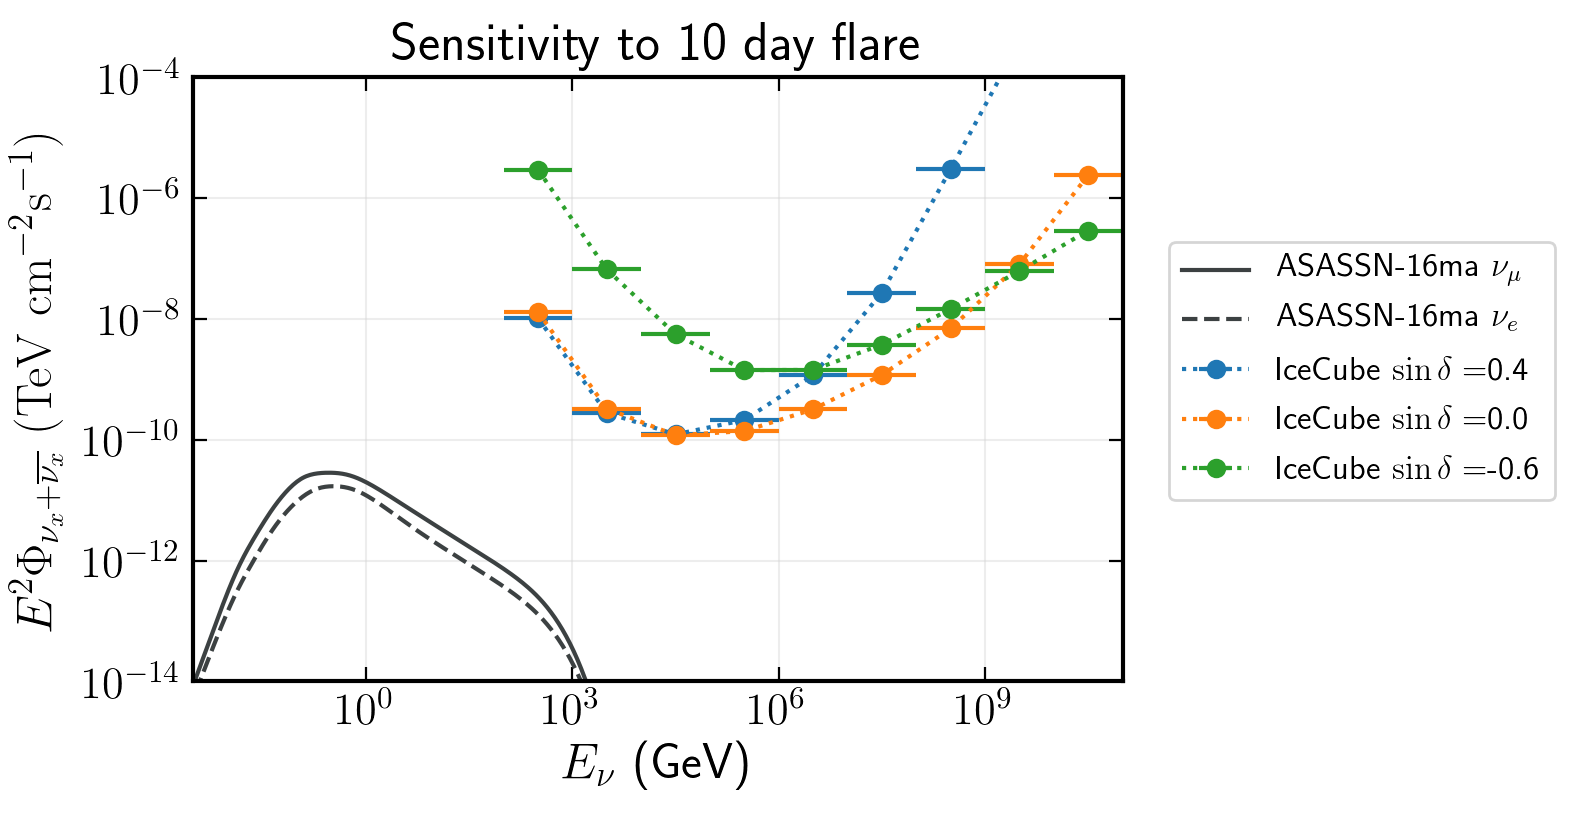

In [20]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (5, 9, 15):
    for dlabel in ['IceCube']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

#cents = np.logspace(0., 5., 11)[1::2]
#greco_diff_low = np.array([diff_sens(cent) for cent in cents])
#greco_diff_high = np.array([diff_sens(cent, num_ev=20) for cent in cents])
#greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

#for ii, cent in enumerate(cents):
#    low_en = cent-cent/bin_width
#    high_en = cent*bin_width-cent 
#    if ii == 0:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0, label = 'IceCube DeepCore')
#    else:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0)
#plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
        
plt.title("Sensitivity to 10 day flare")
plt.loglog()
plt.ylim(1e-14, 1e-4)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/ASASSN-16ma_models_IceCube_only.png', bbox_inches='tight',
           dpi=200)
plt.show()

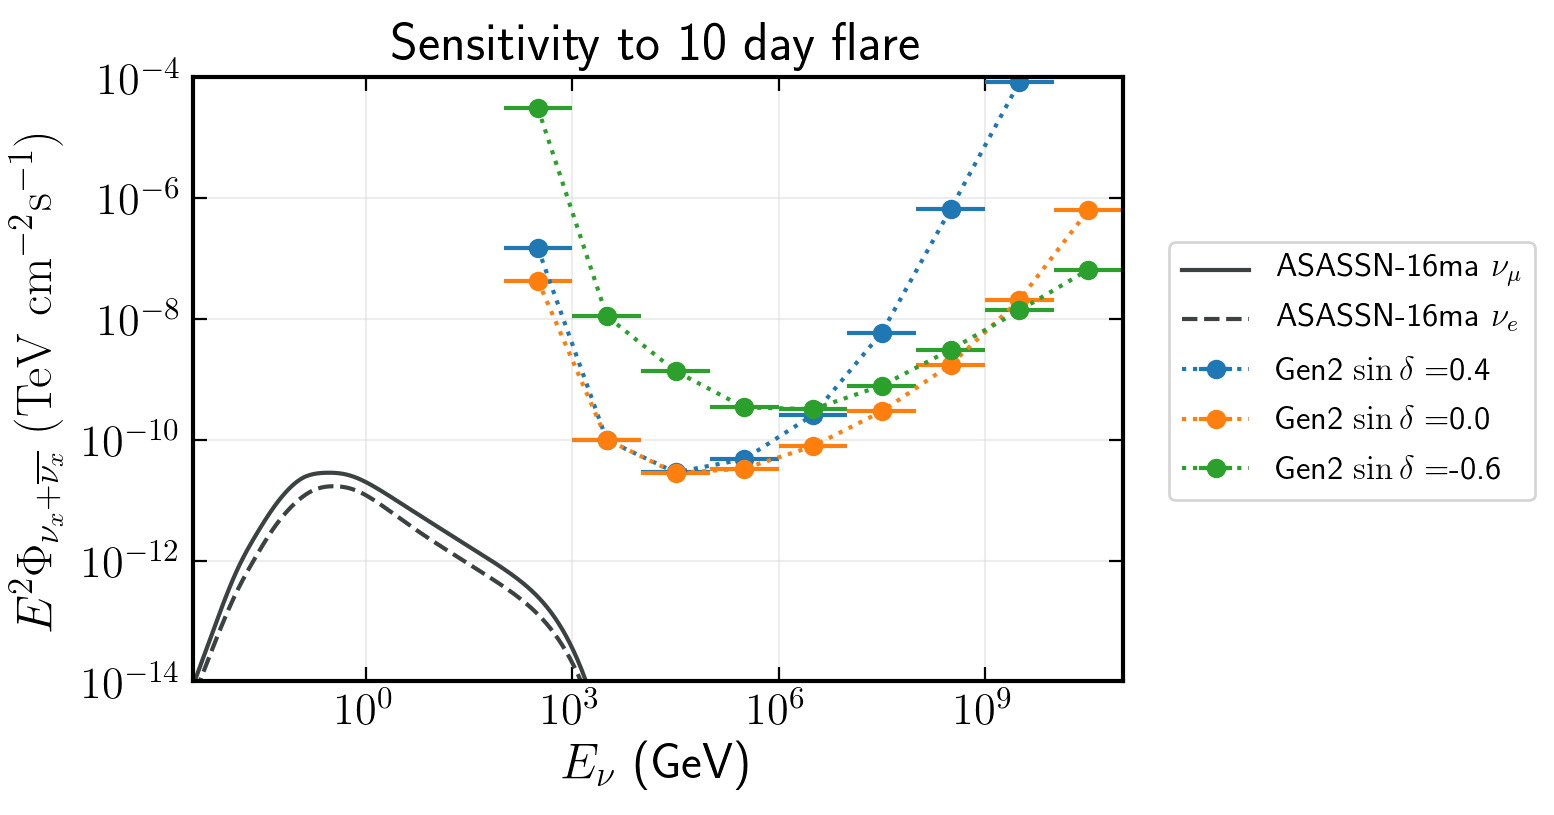

In [21]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (5, 9, 15):
    for dlabel in ['Gen2']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

#cents = np.logspace(0., 5., 11)[1::2]
#greco_diff_low = np.array([diff_sens(cent) for cent in cents])
#greco_diff_high = np.array([diff_sens(cent, num_ev=20) for cent in cents])
#greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

#for ii, cent in enumerate(cents):
#    low_en = cent-cent/bin_width
#    high_en = cent*bin_width-cent 
#    if ii == 0:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0, label = 'IceCube DeepCore')
#    else:
#        plt.fill_between([low_en, high_en], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
#                         color = 'b', alpha=0.2, lw=0.0)
#plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
        
plt.title("Sensitivity to 10 day flare")
plt.loglog()
plt.ylim(1e-14, 1e-4)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/ASASSN-16ma_models_Gen2_only.png', bbox_inches='tight',
           dpi=200)
plt.show()

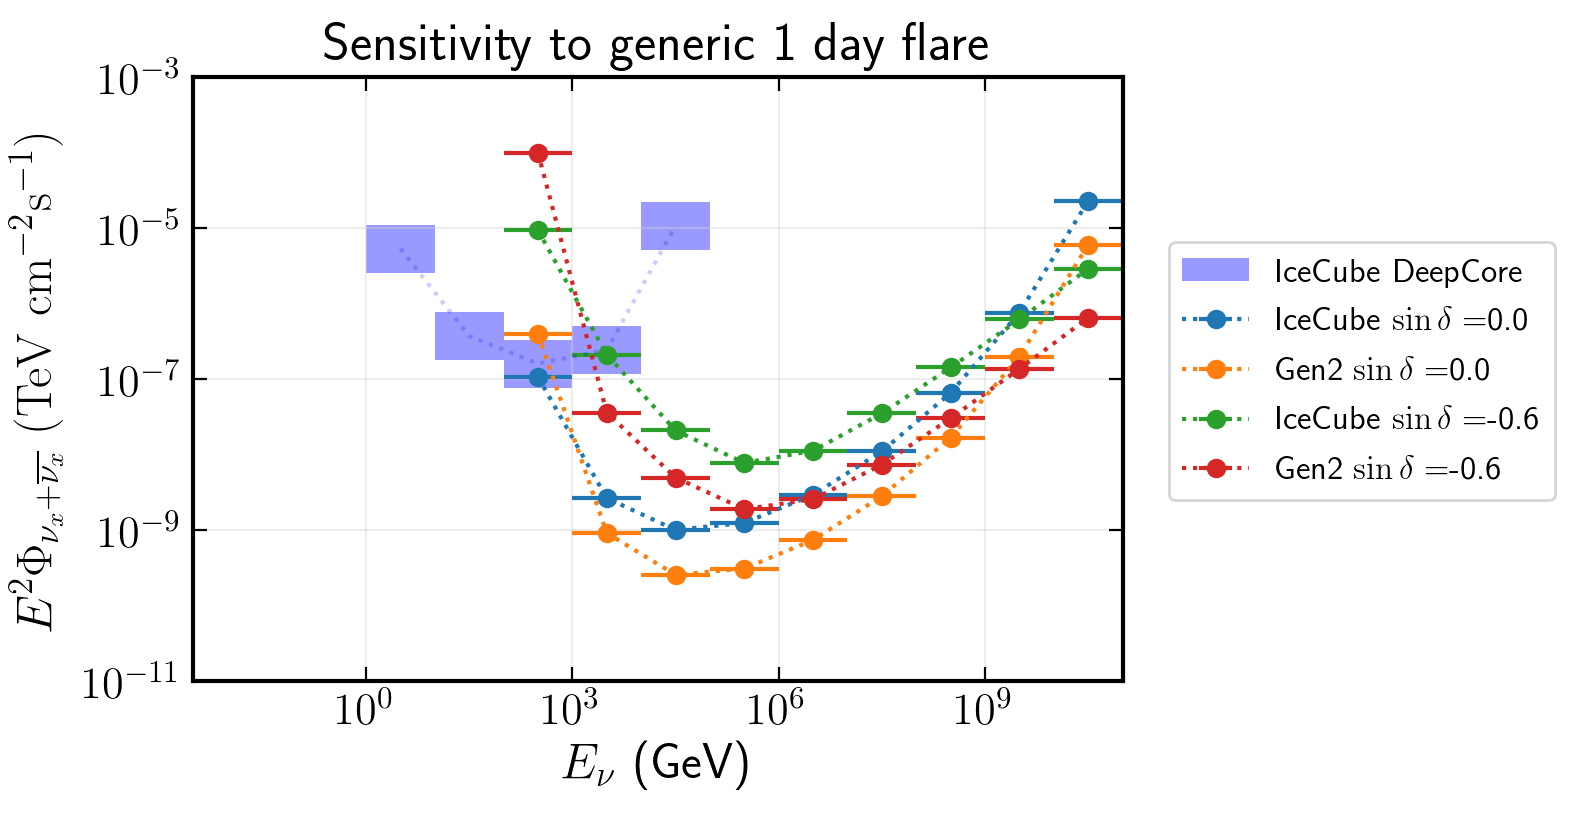

In [12]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in (9, 15):
    for dlabel in ['IceCube', 'Gen2']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
#plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
#plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

cents = np.logspace(0., 5., 11)[1::2]
edges = np.logspace(0., 5., 11)[::2]
greco_diff_low = np.array([diff_sens(cent) for cent in cents])
greco_diff_high = np.array([diff_sens(cent, num_ev=10) for cent in cents])
greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

for ii, cent in enumerate(cents):
    if ii == 0:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0, label = 'IceCube DeepCore')
    else:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0)
plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
plt.title("Sensitivity to generic 1 day flare")
        
plt.loglog()
plt.ylim(1e-11, 1e-3)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/differential_sensitivity_icecube_gen2_and_greco.png', bbox_inches='tight',
           dpi=200)
plt.show()

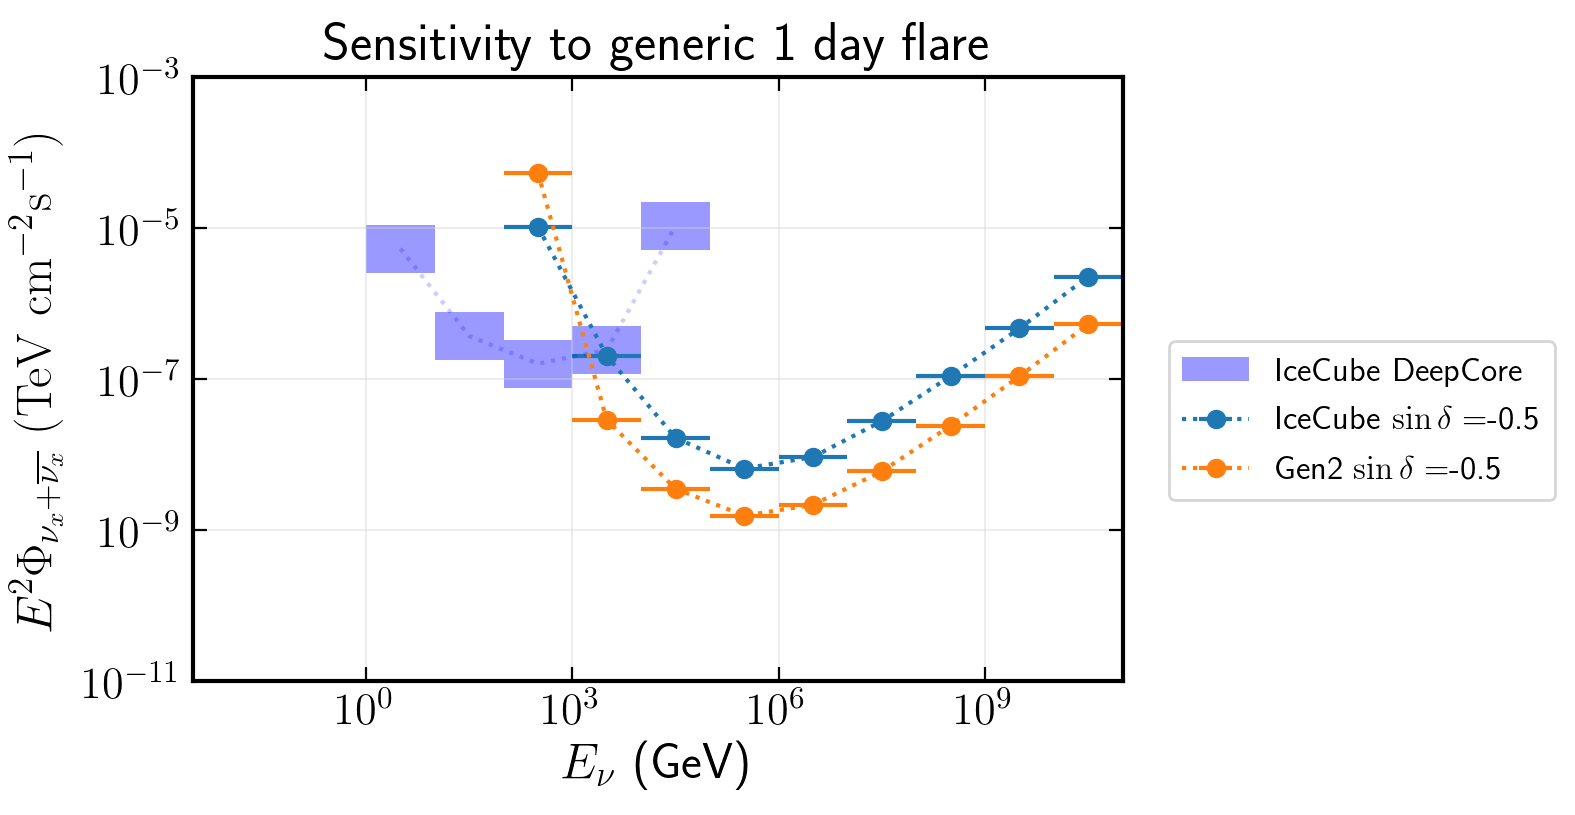

In [14]:
fig = plt.figure(figsize=(6,4), dpi=200)

flux_norm = 1e-12
bin_width = np.sqrt(10**flare_1day['args']['decades'])

for ct_bin in [14]:
    for dlabel in ['IceCube', 'Gen2']:
    #for dlabel in flare_1day['data']['differential_upper_limit'].keys():
        item = flare_1day['data']['differential_upper_limit'][dlabel][str(ct_bin)]
        x = np.asarray(item['e_center'])
        y = np.asarray(item['flux'])*flux_norm
        plt.errorbar(
            x,
            y,
            xerr=[x-x/bin_width, x*bin_width-x],
            marker='o',
            ls=':',
            label=dlabel + r' $\sin\delta=$' + '{:.1f}'.format(sin_dec[ct_bin])
        )
        
#plt.plot(ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
#plt.plot(ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

cents = np.logspace(0., 5., 11)[1::2]
edges = np.logspace(0., 5., 11)[::2]
greco_diff_low = np.array([diff_sens(cent) for cent in cents])
greco_diff_high = np.array([diff_sens(cent, num_ev=10) for cent in cents])
greco_aves = 10**((np.log10(greco_diff_high) + np.log10(greco_diff_low)) / 2.)

for ii, cent in enumerate(cents):
    if ii == 0:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0, label = 'IceCube DeepCore')
    else:
        plt.fill_between([edges[ii], edges[ii+1]], [greco_diff_low[ii]]*2, [greco_diff_high[ii]]*2, 
                         color = 'b', alpha=0.4, lw=0.0)
plt.plot(cents, greco_aves, color='b', alpha = 0.2, ls=':')
plt.title("Sensitivity to generic 1 day flare")
        
plt.loglog()
plt.ylim(1e-11, 1e-3)
plt.xlim(3e-3, 1e11)
plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.ylabel(r'$E^2 \Phi_{\nu_x + \overline{\nu_x}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

plt.savefig('/home/apizzuto/public_html/novae/differential_sensitivity_icecube_gen2_and_greco_galactic_center.png', bbox_inches='tight',
           dpi=200)
plt.show()